In [22]:
%matplotlib inline
from __future__ import division
import h5py
import numpy as np
import lockin
import sigutils
from scipy import signal, optimize, linalg, fftpack
from scipy.optimize import curve_fit
import matplotlib as mpl
mpl.style.use('classic')
import matplotlib.pyplot as plt
from matplotlib import gridspec
import phasekick
import glob
from tqdm import tqdm
import pandas as pd
import collections
idx = pd.IndexSlice
import timedomainfit as td
import pystan

from scipy import signal

fir = signal.firwin(101, 10e3, nyq=500e3, window='blackman')

A_LP = np.exp(-0.2*np.pi*np.arange(0, 10))
A_LP = A_LP / np.sum(A_LP)
fir_LP = signal.convolve(A_LP, fir)

def conv_match_stan(d, out):
    N = d['N']
    y_conv = np.zeros(N)
    popt = get_opt({key: val.mean() for key, val in out.extract().items()})
    y_eval = exp_rise(d['t_eval'], *popt)
    for i in xrange(0, N):
        y_conv[i] = np.dot(d['kern'], y_eval[i:(d['K']+i)])
    return y_conv

def conv_exp(t_eval, A0, dA, k, t0, kern=fir_LP):
    y_eval = exp_rise(t_eval,  A0, dA, k, t0)
    N = y_eval.size - kern.size + 1
    y_conv = np.zeros(N)
    for i in xrange(0, N):
        y_conv[i] = np.dot(kern, y_eval[i:(kern.size+i)])
    return y_conv

def conv_stan(x, kern):
    K = kern.size
    N = x.size - K + 1
    y_conv = np.zeros(N)
    for i in xrange(0, N):
        y_conv[i] = np.dot(kern, x[i:(K+i)])
    return y_conv


def align_labels(axes_list,lim, axis='y'):
    for ax in axes_list:
        t = ax.yaxis.label.get_transform()
        x,y = ax.yaxis.label.get_position()
        ax.yaxis.set_label_coords(lim,y,t)
        

def exp_rise(t_, A0, dA, k, t0):
    t = t_ - t0
    return np.where(t > 0, -dA * np.expm1(-k*t), 0) + A0

def conv_exp_rise_LP(t_, A0, dA, k, t0):
    x = exp_rise(t_, A0, dA, k, t0)
    return signal.fftconvolve(x, fir_LP, 'valid')

In [15]:
# size = 9
# rcParams = {'figure.figsize': (2.0, 2.5), 'font.size': size,
# #             'lines.markersize': ,
#             'lines.linewidth': 1,
#             'xtick.labelsize': size, 'ytick.labelsize': size,}

In [16]:
fh = h5py.File('../../data/pk-EFM/151218-011055-100sun-phasekick-768.h5', 'r')

In [17]:
b = td.signal_average_gr_parab(fh['data'], -1.5e-3, 1.5e-3, invert=False, align_voltage=True)

Response:
f   mag       dB
    0.000 1.000    0.000
 3096.515 0.983   -0.152
 6193.029 0.927   -0.661
24772.117 0.096  -20.353
30965.146 0.012  -38.785
49544.233 0.000 -101.978
61930.291 0.000 -111.035
500000.000 0.000 -179.310


In [18]:
b.li = lockin.LockIn(b.t, b.x, 1e6)
b.li.run(fir=fir)
b.li.phase(tf=-0.0010)

(-10, 100)

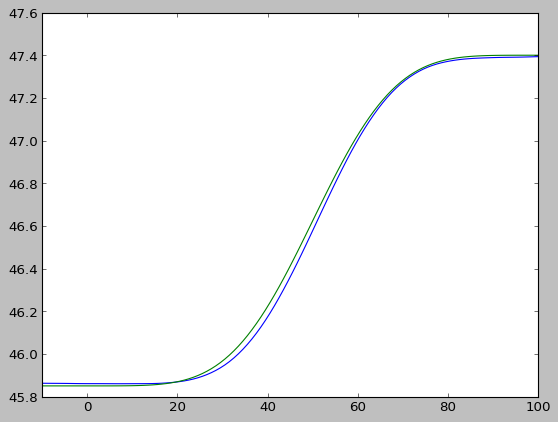

In [19]:
plt.plot(b.li('t')*1e6 + (b.li.fir.size-1)/2, b.li('A'))
plt.plot(b.li('t')*1e6 + (b.li.fir.size-1)/2, 45.85 + 1.55*signal.fftconvolve(np.where(b.li('t') > 0, 1, 0), fir, 'same'))
plt.xlim(-10, 100)

In [20]:
m = phasekick.masklh(b.li('t')*1e6,  -150, 150)
tfit = b.li('t')[m] * 1e6
Afit_ = b.li('A')[m] 
A0 = 45.85
Afit = Afit_ - A0

In [42]:
mod = pystan.StanModel('deconv.stan')

In [43]:
def stan_data(tfit, Afit, kern,
              mu_dy=1.5, sigma_dy=1.0,
              mu_k=10.0,
              mu_t0=1.0,
              mu_y0=0, sigma_y0=1.0,
              sigma_t0=1.0):
    K = kern.size
    N = tfit.size - K + 1
    y = Afit[(K//2):-(K//2)+1]
    return dict(N=N, K=K, y=y, t_eval=tfit, kern=kern, mu_dy=mu_dy, sigma_dy=sigma_dy,
                mu_k=mu_k, mu_y0=mu_y0, sigma_y0=sigma_y0, mu_t0=mu_t0, sigma_t0=sigma_t0)

In [44]:
d = stan_data(tfit + 3, Afit, fir_LP)
d2 = stan_data(tfit[40:-40] + 3, Afit[40:-40], fir_LP)

In [45]:
out3 = mod.sampling(data=d, iter=5000, chains=1, )

In [46]:
# out2 = mod.sampling(data=d, iter=5000, chains=4, )

In [47]:
# out3 = mod.sampling(data=d2, iter=5000, chains=4)

In [48]:
def get_opt(d):
    return np.array([d['y0'], d['dy'], d['k'], d['t0']])

In [49]:
# out3.extract()

In [50]:
ma = np.ones(d2['kern'].size)/d2['K']
ts = conv_stan(d2['t_eval'], ma)
tss = signal.convolve(d2['t_eval'], ma, 'valid')

In [57]:
popt = get_opt({key: val.mean() for key, val in out3.extract().items()})

In [54]:
def centrange(x):
    non_centered = np.arange(x.size)
    return non_centered - np.mean(non_centered)

In [55]:
b.li.t_us = b.li.t * 1e6
ts = conv_stan(d2['t_eval'], ma) + (fir_LP.size-1.0)/2

In [58]:
y_conv = conv_exp(d2['t_eval'], *popt)

/Users/ryandwyer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: overflow encountered in expm1


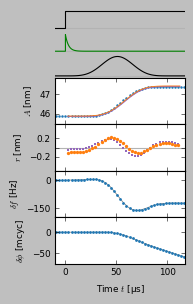

In [465]:
angle = 90
mpl.rc('font', size=8)
fig = plt.figure(figsize=(2.1, 4.0))
gs = mpl.gridspec.GridSpec(33, 1)
axes = []
iend = [3, 6, 9, 15, 21, 27]
axes.append(fig.add_subplot(gs[:iend[0]]))
for i,i_next in zip(iend[:-1], iend[1:]):
    axes.append(fig.add_subplot(gs[i:i_next], sharex=axes[0]))

axes.append(fig.add_subplot(gs[iend[-1]:]))
fig.subplots_adjust(wspace=0.0, hspace=0)

tpts = np.array([-50, 0, 0, 150])
Vpts = np.array([0, 0, 1, 1])
axes[0].plot(tpts, Vpts, 'k')
axes[0].set_ylim(-0.2, 1.2)
axes[0].set_yticks([0, 1])
axes[0].set_yticklabels(['$0$', ''])
axes[0].set_xticklabels([''])

axes[0].set_xlim(-10, 118)

axes[0].set_ylabel("$V_\\mathrm{t}$")


t_exp_pos = np.r_[np.linspace(0,20, 101), 200]
t_exp = np.r_[[-50, 0], t_exp_pos]
x_exp = np.r_[0, 0, np.exp(-t_exp_pos/3.0)]

Ndec = 3

pts_color = u'#ff7f0e'

axes[1].plot(t_exp, x_exp, 'g')
axes[1].set_ylim(-0.2, 1.2)
axes[1].set_ylabel("$G$")

axes[2].plot(np.r_[-50, np.arange(fir_LP.size), 150],
             np.r_[0, fir_LP, 0],
            'k')

axes[2].set_ylim(fir_LP.max()*-0.1, fir_LP.max()*1.1)

axes[2].set_ylabel("$H$")

for ax in [axes[i] for i in [0, 1, 2, 4]]:
    ax.axhline(color='0.7', zorder=0)

ax3 = axes[3]
ax4 = axes[4]

pts_color = u'#1f77b4'
light_color = u'#ff7f0e'
dark_color = u'#9467bd'

ax4.plot(ts[::Ndec], (y_conv - d2['y'])[::Ndec]*1e3, 's',
         color=dark_color,
         markersize=2.5, alpha=1, markeredgewidth=0, zorder=1)

ax3.plot(ts, (conv_match_stan(d2, out3)+A0), color=dark_color, linestyle='-',alpha=1, # dashes=(10, 10),
         linewidth=1, zorder=1)
ks = [1e4]
ys = [conv_exp(d2['t_eval'], 0.0006, 1.5494081695, k, 0) for k in ks]

for y, color in zip(ys, [light_color]):
    ax3.plot(ts, (y+A0)+0.03, color=color, linewidth=0.75, alpha=1, zorder=11, )
    ax4.plot(ts[::Ndec], (y - d2['y'])[::Ndec]*1e3, '.', color=color, alpha=1, markeredgewidth=0)
# ax1.plot(x_conv)


t_us = b.li('t_us') + (fir_LP.size-1.0)/2
# ax3.plot(t_us, b.li('A'), '0.5', linewidth=0.7, zorder=0)
ax3.plot(t_us[::Ndec], b.li('A')[::Ndec], '.', markersize=4.5, color=pts_color, alpha=1.0, zorder=0, markeredgewidth=0)
axes[3].set_ylabel('$A$ [nm]', rotation=angle)



ax3.set_ylim(45.45, 47.85)

ax3.set_yticks([46, 47])
ax4.set_yticks([-20, 0, 20])
ax4.set_yticklabels([u'−0.2', '', '0.2'])
ax4.set_ylim(-50, 50)
axes[4].set_ylabel('$r$ [nm]', rotation=angle)

axes[5].plot(t_us[::Ndec], b.li('df')[::Ndec], '.', color=pts_color, markersize=5, alpha=1, zorder=1, markeredgewidth=0)
axes[5].plot(t_us, b.li('df'), '0.5', linewidth=0.7, zorder=0)
axes[5].set_yticks([0, -150])
axes[5].set_ylabel('$\\delta f$ [Hz]', rotation=angle)

axes[6].plot(t_us[::Ndec], b.li('dphi')[::Ndec]*1e3, '.', color=pts_color, markersize=5, alpha=1, zorder=1, markeredgewidth=0)
axes[6].plot(t_us, b.li('dphi')*1e3,'0.5', linewidth=0.7, zorder=0)
axes[6].set_xlim(*axes[0].get_xlim())
axes[6].set_ylim(-75, 35)
axes[6].set_yticks([-50, 0])
axes[6].set_ylabel('$\\delta \\phi$ [mcyc]', rotation=angle)
axes[6].set_xlabel(u"Time $t$ [µs]")

for ax in axes[:3]:
    ax.set_frame_on(False)
    ax.set_axis_off()

for ax in axes[-2:]:
    ax.set_xticks([0, 50, 100])


In [466]:
align_labels(axes[3:], 19)
# fig.savefig('ex.pdf', bbox_inches='tight', transparent=True)

In [467]:
# ylabel = ax3.yaxis.get_label()
# ylabel.get_position()
# for ax in axes[3:]:
#     ylabel = ax.yaxis.get_label()
#     ylabel.set_position((xloc, 0.35))
    

In [468]:
fig.savefig('ex.pdf', bbox_inches='tight', transparent=True)

In [469]:
!open ex.pdf

In [461]:
!cp ex.pdf /Users/ryandwyer/Dropbox/_JAM_MS__Dwyer201511__Phasekick__figs/raw-figures/tr-efm-ultra-fast.pdf

In [374]:
samples = out.extract()

NameError: name 'out' is not defined

In [ ]:
samp_mean = {key: np.percentile(val, 50) for key, val in samples.items()}

In [168]:
samp_mean

{u'dy': 1.5472435320194882,
 u'k': 1.1439060269795223,
 u'lp__': 429.92173364906228,
 u'sigma': 0.060935574302912014,
 u't0': -0.7731747777326049,
 u'y0': 0.02617199026858678}

- Naive demodulation only shows an impulsive shift.

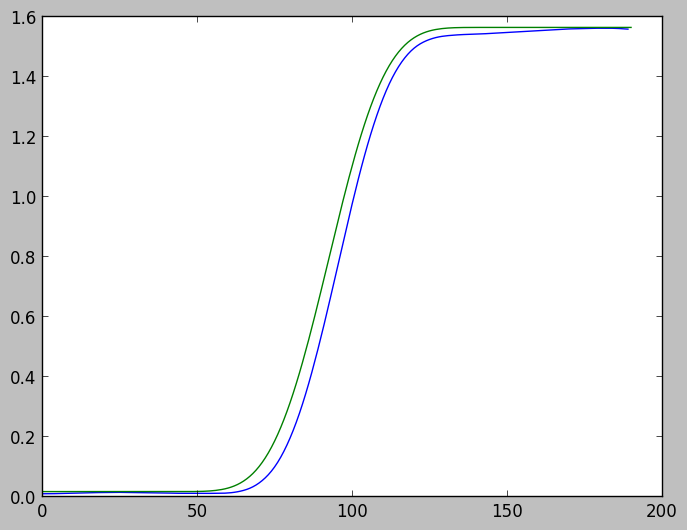

In [170]:
plt.plot(d['y'])
x = conv_exp_rise_LP(tfit, samp_mean['y0']-0.01, samp_mean['dy'], samp_mean['k'], 0)
plt.plot(x)

In [ ]:
plt.plot(bi_all.t_us, bi_all.resid)
plt.xlim(-10, 100)
plt.ylim(-3.5, 5.5)